In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
# import PIL
import tensorflow as tf
import pickle5 as pickle
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import glob
from random import shuffle

In [2]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [3]:
# import pathlib
# data_dir = pathlib.Path('E:/Users/sentinel_industry/downloaded_aois/')


In [4]:
x_size = 230
y_size = 230
def load_features(name):
    decoded = name.decode("UTF-8")
    if os.path.exists(decoded):
        with open(decoded, 'rb') as f:
            file = pickle.load(f)
            label = tf.strings.split(tf.strings.split(name, '/')[-1], '\\')[-2]
            if label == 'coal':
                label = [1,0,0]
            elif label == 'steel':
                label = [0,1,0]
            else: label = [0,0,1]
            features = np.array([file['B02'][0][0:x_size,0:y_size], file['B03'][0][0:x_size,0:y_size], file['B04'][0][0:x_size,0:y_size],file['B08'][0][0:x_size,0:y_size]]).transpose(1,2,0)
            features = np.expand_dims(features, axis=0)
            return features, label
            # I have commented the line below but this should return
            # the features and the label in a one hot vector
            # return file['features'], file['targets']
    else:
        print("Something went wrong!")
        exit(-1)

In [5]:
path = 'E:/Users/sentinel_industry/downloaded_aois/coal/'

pkl_files = glob.glob((path+"*.pickle"))


In [6]:
print(len(pkl_files))

2258


In [7]:
path_steel = 'E:/Users/sentinel_industry/downloaded_aois/steel/'
pkl_files_steel = glob.glob((path_steel+"*.pickle"))

In [8]:
path_steel_no_ind = 'E:/Users/sentinel_industry/downloaded_aois/steel/no_ind/'
pkl_files_steel_no_ind = glob.glob((path_steel_no_ind+"*.pickle"))

In [9]:
path_coal_no_ind = 'E:/Users/sentinel_industry/downloaded_aois/coal/no_ind/'
pkl_files_coal_no_ind = glob.glob((path_coal_no_ind+"*.pickle"))

In [10]:
print(len(pkl_files_steel))

1722


In [11]:
pkl_files = pkl_files + pkl_files_steel + pkl_files_steel_no_ind + pkl_files_coal_no_ind
shuffle(pkl_files)

In [12]:
# from itertools import chain

# pkl_files = list(chain.from_iterable(zip(pkl_files, pkl_files_steel)))


In [13]:
print(len(pkl_files))

8077


In [14]:
dataset_len=len(pkl_files)

In [15]:
dataset = tf.data.Dataset.from_tensor_slices((pkl_files))

def data_loader(filename):
    features, labels = tf.numpy_function(load_features, [filename], [tf.uint16, tf.int32])
    # features.set_shape((None, 242,242,4))
    # labels.set_shape(( 1))
    return features, labels

dataset = dataset.map(data_loader)
               # load_features, [filename], [tf.uint16, tf.string])))

In [175]:
dataset.shuffle(100)

train_size = np.floor(0.8 * dataset_len)
valid_size = np.floor(0.1 * dataset_len)
test_size = np.floor(0.1 * dataset_len)

train = dataset.take(train_size)
remaining = dataset.skip(train_size)
valid = remaining.take(valid_size)
test = remaining.skip(valid_size)

In [176]:
train = train.shuffle(100,  reshuffle_each_iteration=True)

In [21]:
in_seed = 42
resize_rescale_augment = tf.keras.Sequential([
    layers.RandomRotation(0.2, seed=in_seed, input_shape=(x_size,y_size,4)),  # here, maybe try larger values
    # layers.RandomCrop(120,120, seed=in_seed, input_shape=(x_size,y_size,4)),  # to be changed with centercrop for data augmentation/ use centre first, then random?
    layers.CenterCrop(120,120, ),
    layers.Rescaling(1./10000),#,input_shape=(240,240,4)), # I think the data is scaled to 10000
    layers.RandomFlip("horizontal_and_vertical", seed=in_seed), 
])

In [178]:
# dataset = dataset.map((
#   lambda x, y: (resize_and_rescale(x), y)))

In [179]:
for image_batch, labels_batch in dataset:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(1, 230, 230, 4)
(3,)


In [18]:
iterator=tf.compat.v1.data.make_one_shot_iterator(dataset)

In [19]:
def convert_onehot(next_element):
    if (next_element[1].numpy() == np.array([0, 0, 1])).all(): return 'no industry'
    elif (next_element[1].numpy() == np.array([0, 1, 0])).all(): return 'steel'
    elif (next_element[1].numpy() == np.array([1, 0, 0])).all(): return 'coal'
    else: return 'not valid'

def convert_onehot_list(next_element):
    if (next_element == np.array([0, 0, 1])).all(): return 'no industry'
    elif (next_element == np.array([0, 1, 0])).all(): return 'steel'
    elif (next_element == np.array([1, 0, 0])).all(): return 'coal'
    else: return 'not valid'

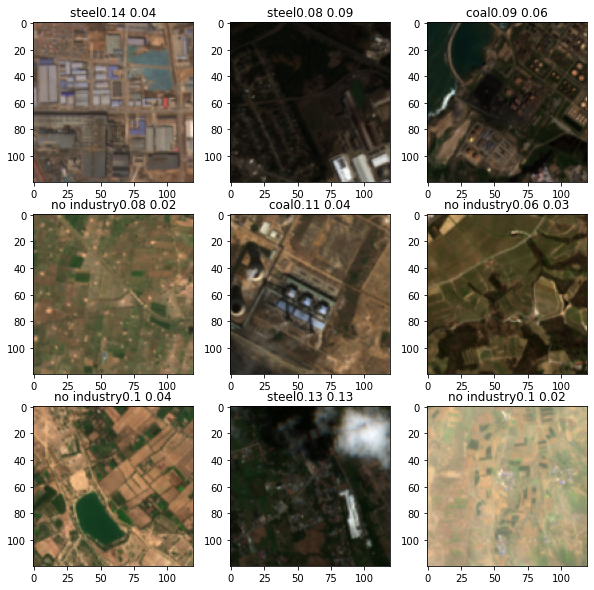

In [57]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    next_element = iterator.get_next()
    im = resize_rescale_augment(next_element[0])
    plt.imshow(np.flip(im[0,:,:,0:3]/np.max(im[0,:,:,0:3]), axis=2))
    plt.title(convert_onehot(next_element) + str(np.round(im[0,:,:,0:3].numpy().mean(), 2))+' ' +str(np.round(im[0,:,:,0:3].numpy().std(),2)))

In [47]:
0.04 0.4

SyntaxError: invalid syntax (3928029516.py, line 1)

In [ ]:
next_element[1].numpy().all()

In [ ]:
import importlib.util
import sys
spec = importlib.util.spec_from_file_location("module.name", "/path/to/file.py")
foo = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = foo
spec.loader.exec_module(foo)

In [39]:
def load_features2(name):
    decoded = name
    if os.path.exists(decoded):
        with open(decoded, 'rb') as f:
            file = pickle.load(f)
            label = tf.strings.split(tf.strings.split(name, '/')[-1], '\\')[-2]
            if label == 'coal':
                label = [1,0,0]
            elif label == 'steel':
                label = [0,1,0]
            else: label = [0,0,1]
            features = np.array([file['B02'][0][0:x_size,0:y_size], file['B03'][0][0:x_size,0:y_size], file['B04'][0][0:x_size,0:y_size],file['B08'][0][0:x_size,0:y_size]]).transpose(1,2,0)
            features = np.expand_dims(features, axis=0)
            return features, label
            # I have commented the line below but this should return
            # the features and the label in a one hot vector
            # return file['features'], file['targets']
    else:
        print("Something went wrong!")
        exit(-1)

E:/Users/sentinel_industry/downloaded_aois/steel\GASTARE0001.pickle
E:/Users/sentinel_industry/downloaded_aois/steel\GASTARE0004.pickle
E:/Users/sentinel_industry/downloaded_aois/steel\GASTARE0005.pickle
E:/Users/sentinel_industry/downloaded_aois/steel\GASTARE0006.pickle
E:/Users/sentinel_industry/downloaded_aois/steel\GASTARE0008.pickle
E:/Users/sentinel_industry/downloaded_aois/steel\GASTARG0001.pickle
E:/Users/sentinel_industry/downloaded_aois/steel\GASTARG0002.pickle
E:/Users/sentinel_industry/downloaded_aois/steel\GASTARG0003.pickle
E:/Users/sentinel_industry/downloaded_aois/steel\GASTARG0004.pickle


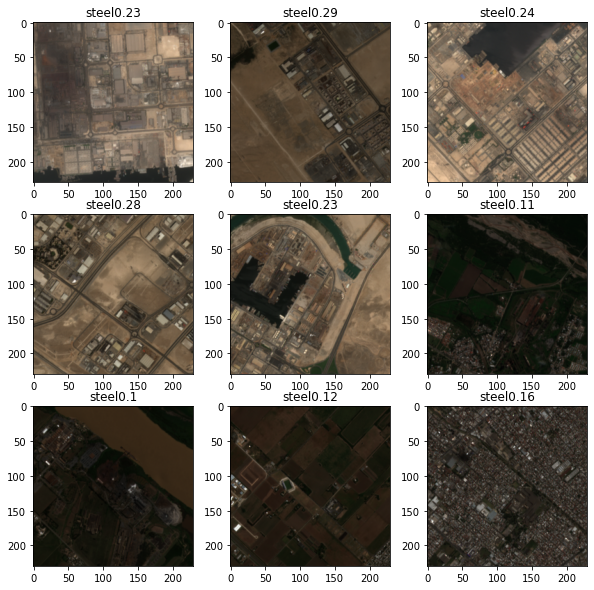

In [231]:
plt.figure(figsize=(10, 10))
for i,file in enumerate(pkl_files_steel[18+-18:27+-18]):
    feat,la = load_features2(file)
    feat = feat/10000
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.flip(feat[0,:,:,0:3], axis=2)/np.max(feat[0,:,:,0:3]))
    plt.title(convert_onehot_list(la)+str(feat.mean().round(2)))
    # print(convert_onehot_list(la))
    print(file)

In [106]:
! del /s "E:/Users/sentinel_industry/downloaded_aois/steel\GASTVEN0011.pickle"

Datei wurde gel”scht - E:\Users\sentinel_industry\downloaded_aois\steel\GASTVEN0011.pickle
Datei wurde gel”scht - E:\Users\sentinel_industry\downloaded_aois\steel\no_ind\GASTVEN0011.pickle


In [40]:
import os
for i,file in enumerate(pkl_files):
    feat,la = load_features2(file)
    feat = feat/10000
    if feat.mean() > 0.45: 
        print(file)
        os.remove(file)

E:/Users/sentinel_industry/downloaded_aois/steel/no_ind\SCN00369.pickle
E:/Users/sentinel_industry/downloaded_aois/steel\SRU00013.pickle
E:/Users/sentinel_industry/downloaded_aois/steel\GASTCHN0187.pickle
E:/Users/sentinel_industry/downloaded_aois/coal/no_ind\G107215.pickle
E:/Users/sentinel_industry/downloaded_aois/coal/no_ind\G107328.pickle
E:/Users/sentinel_industry/downloaded_aois/steel/no_ind\SIN00035.pickle
E:/Users/sentinel_industry/downloaded_aois/coal\G112455.pickle
E:/Users/sentinel_industry/downloaded_aois/coal/no_ind\G106706.pickle
E:/Users/sentinel_industry/downloaded_aois/coal/no_ind\G105656.pickle
E:/Users/sentinel_industry/downloaded_aois/coal\G113998.pickle
E:/Users/sentinel_industry/downloaded_aois/coal\G106015.pickle
E:/Users/sentinel_industry/downloaded_aois/steel/no_ind\SCA00008.pickle
E:/Users/sentinel_industry/downloaded_aois/coal/no_ind\G113691.pickle
E:/Users/sentinel_industry/downloaded_aois/steel/no_ind\SCN00253.pickle
E:/Users/sentinel_industry/downloaded_ao